In [ ]:
pip install transformers

     |████████████████████████████████| 2.6 MB 8.6 MB/s 
     |████████████████████████████████| 895 kB 52.7 MB/s 
     |████████████████████████████████| 3.3 MB 56.7 MB/s 
     |████████████████████████████████| 636 kB 64.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!apt-get --purge remove cuda nvidia* libnvidia-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get remove cuda-*
!apt autoremove
!apt-get update

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'nvidia-kernel-common-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-325-updates' for glob 'nvidia*'
Note, selecting 'nvidia-346-updates' for glob 'nvidia*'
Note, selecting 'nvidia-driver-binary' for glob 'nvidia*'
Note, selecting 'nvidia-331-dev' for glob 'nvidia*'
Note, selecting 'nvidia-304-updates-dev' for glob 'nvidia*'
Note, selecting 'nvidia-compute-utils-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-384-dev' for glob 'nvidia*'
Note, selecting 'nvidia-libopencl1-346-updates' for glob 'nvidia*'
Note, selecting 'nvidia-fs-prebuilt' for glob 'nvidia*'
Note, selecting 'nvidia-driver-440-server' for glob 'nvidia*'
Note, selecting 'nvidia-340-updates-uvm' for glob 'nvidia*'
Note, selecting 'nvidia-dkms-450-server' for glob 'nvidia*'
Note, selecting 'nvidia-kernel-common' for glob 'nvidia*'
Note, selecting 'nvidia-kernel-source-440-server' for glob 'nvidia*'


In [ ]:
!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
!apt-get update
!apt-get install cuda-9.2

--2021-08-07 06:25:51--  https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Resolving developer.nvidia.com (developer.nvidia.com)... 152.199.0.24
Connecting to developer.nvidia.com (developer.nvidia.com)|152.199.0.24|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://developer.nvidia.com/compute/cuda/9.2/prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 [following]
--2021-08-07 06:25:52--  https://developer.nvidia.com/compute/cuda/9.2/prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Reusing existing connection to developer.nvidia.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb?xIOyVCeyhQlX0XhfIkblTk6sebX_9Zusl8XQSjmt2OFimH2fwrpMm93k3apDDjFydkh6RkI42ZTnbnk1mT4-bZjDsJ_-1rJjGd4NBCncibwVjwYfa

In [ ]:
import sys
import os
import math
import warnings
import torch
import pandas as pd 
import numpy as np
import matplotlib as plt
import seaborn as sns

from transformers import AutoModelForSequenceClassification, AutoTokenizer
from IPython.display import clear_output

In [ ]:
torch.cuda.is_available()

True

In [ ]:
def list2chunks(a, n):
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

class ZeroShotClassifier():
    """
    interface to Zero Shot Topic Classifier
    """

    def __init__(self, model_name='facebook/bart-large-mnli', device=None):
        """
        ZeroShotClassifier constructor
        Args:
          model_name(str): name of a BART NLI model
          device(str): device to use (e.g., 'cuda', 'cpu')
        """
        if 'mnli' not in model_name and 'xnli' not in model_name:
            raise ValueError('ZeroShotClasifier requires an MNLI or XNLI model')
        try:
            import torch
        except ImportError:
            raise Exception('ZeroShotClassifier requires PyTorch to be installed.')
        self.torch_device = device
        if self.torch_device is None: self.torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name).to(self.torch_device)


    def predict(self, docs, labels=[], include_labels=False, multilabel=True,
               max_length=512, batch_size=8, nli_template='This text is about {}.',  topic_strings=[]):
        """
        This method performs zero-shot text classification using Natural Language Inference (NLI).
        Args:
          docs(list|str): text of document or list of texts
          labels(list): a list of strings representing topics of your choice
                        Example:
                          labels=['political science', 'sports', 'science']
          include_labels(bool): If True, will return topic labels along with topic probabilities
          multilabel(bool): If True, labels are considered independent and multiple labels can predicted true for document and be close to 1.
                            If False, scores are normalized such that probabilities sum to 1.
          max_length(int): truncate long documents to this many tokens
          batch_size(int): batch_size to use. default:8
                           Increase this value to speed up predictions - especially
                           if len(topic_strings) is large.
          nli_template(str): labels are inserted into this template for use as hypotheses in natural language inference
          topic_strings(list): alias for labels parameter for backwards compatibility
        Returns:
          inferred probabilities or list of inferred probabilities if doc is list
        """

        # error checks
        is_str_input = False
        if not isinstance(docs, (list, np.ndarray)): 
            docs = [docs]
            is_str_input = True
        if not isinstance(docs[0], str): raise ValueError('docs must be string or a list of strings representing document(s)')
        if len(labels) > 0 and len(topic_strings) > 0: raise ValueError('labels and topic_strings are mutually exclusive')
        if not labels and not topic_strings: raise ValueError('labels must be a list of strings')
        if topic_strings: 
            labels = topic_strings

        # convert to sequences
        sequence_pairs = []
        for premise in docs:
            sequence_pairs.extend([[premise, nli_template.format(label)] for label in labels])
        if batch_size  > len(sequence_pairs): batch_size = len(sequence_pairs)
        if len(sequence_pairs) >= 100 and batch_size==8:
            warnings.warn('TIP: Try increasing batch_size to speedup ZeroShotClassifier predictions')
        num_chunks = math.ceil(len(sequence_pairs)/batch_size)
        sequence_chunks = list2chunks(sequence_pairs, n=num_chunks)

        # inference
        with torch.no_grad():
            outputs = []
            for sequences in sequence_chunks:
                batch = self.tokenizer.batch_encode_plus(sequences, return_tensors='pt', max_length=max_length, truncation='only_first', padding=True).to(self.torch_device)
                logits = self.model(batch['input_ids'], attention_mask=batch['attention_mask'], return_dict=False)[0]
                outputs.extend(logits.cpu().detach().numpy())
                #entail_contradiction_logits = logits[:,[0,2]]

                #probs = entail_contradiction_logits.softmax(dim=1)
                #true_probs = list(probs[:,1].cpu().detach().numpy())
                #result.extend(true_probs)
        outputs = np.array(outputs)
        outputs = outputs.reshape((len(docs), len(labels), -1))

        # process outputs
        # 2020-08-24: modified based on transformers pipeline implementation
        if multilabel:
            # softmax over the entailment vs. contradiction dim for each label independently
            entail_contr_logits = outputs[..., [0, -1]]
            scores = np.exp(entail_contr_logits) / np.exp(entail_contr_logits).sum(-1, keepdims=True)
            scores = scores[..., 1]
        else:
            # softmax the "entailment" logits over all candidate labels
            entail_logits = outputs[..., -1]
            scores = np.exp(entail_logits) / np.exp(entail_logits).sum(-1, keepdims=True)
        scores = scores.tolist()
        if include_labels:
            scores = [list(zip(labels, s)) for s in scores]
        if is_str_input: scores = scores[0]
        return scores

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = 'drive/My Drive/NLP_research_notes/NLP_research/'

In [ ]:
df_orig = pd.read_csv(path + 'google_scholar_selected.csv')

df = df_orig
df.drop_duplicates(subset='Title', keep='first', inplace=True)
df.reset_index(drop=True, inplace=True)
df

Unnamed: 0  ...                                           Abstract
0               0  ...  Online surveys are a popular mechanism for per...
1               1  ...  Keystroke inference attacks pose an increasing...
2               2  ...  For the past two decades, the security communi...
3               3  ...  The first keylogging side channel attack was d...
4               4  ...  In a Futures-Exchange, such as the Chicago Mer...
...           ...  ...                                                ...
10445       11140  ...  A successful real-time intrusion detection is ...
10446       11141  ...  The present paper embodies a technique for on-...
10447       11142  ...  Currently the HoneyComb architecture is alread...
10448       11143  ...  This paper presents a methodology for testing ...
10449       11147  ...  This paper describes techniques for producing ...

[10450 rows x 9 columns]

In [ ]:
df['Corpus'] = df[['Title', 'Abstract']].apply(lambda x: '. '.join(x), axis = 1)
corpus = df['Corpus']

labels = pd.read_csv(path + 'domains.csv', header=None)
# labels = labels[0].tolist()

In [ ]:
labels.head()

0                     1
0  NaN                Domain
1  0.0  Security and privacy
2  1.0  Security and privacy
3  2.0  Security and privacy
4  3.0  Security and privacy

In [ ]:
labels = labels[1].tolist()

In [ ]:
zsl = ZeroShotClassifier()

In [ ]:
def top_classes(text, labels, titles):
    modeled_topic = zsl.predict(text, labels = labels, include_labels = True, batch_size = 64)
    df_result = pd.DataFrame(modeled_topic, columns = ["Label", "Confidence Score"])
    assigned_label = df_result.sort_values("Confidence Score", ascending = False).head(1)
    assigned_label["Title"] = titles
    assigned_label = assigned_label[["Title", "Label", "Confidence Score"]]
    return assigned_label

def barcount_plot(labels, title):
    ax = labels.value_counts().plot(kind='bar',
                                        figsize=(14,8))
    ax.set_xlabel("Labels")
    ax.set_ylabel("Frequency")

In [ ]:
%%time

df_labeled = pd.DataFrame(columns = ["Title", "Label", "Confidence Score"])

for x in range(len(df)):
    #top_title = top_classes(df["Title"][x], labels, df["Title"][x])
    #top_abstract = top_classes(df["Abstract"][x], labels, df["Title"][x])
    top_label = top_classes(df["Corpus"][x], labels, df["Title"][x])

    #results = [top_title, top_abstract, top_corpus]
    #doc_labels = pd.concat(results)
    #top_label = doc_labels[doc_labels["Likelihood"] == doc_labels["Likelihood"].max()]
    df_labeled = df_labeled.append(top_label)

    clear_output(wait=True)
    print(((x/(len(df)-1))*100), "Completed. There are", ((len(df)-1)-x), "samples remaining.")

6.574791846109676 Completed. There are 9762 samples remaining.


In [ ]:
df_labeled.to_csv(path + '\zsl_labeled_domains_corpus.csv', index = False, header = True)

NameError: ignored

In [ ]:
df_labeled = pd.read_csv(path + '\zsl_labeled_domains_corpus.csv')

In [ ]:
df_labeled

Title  \
0      Surveylance: Automatically Detecting Online Su...   
1      EyeTell: Video-Assisted Touchscreen Keystroke ...   
2                            Understanding Linux Malware   
3                          SoK: Keylogging Side Channels   
4      FuturesMEX: Secure, Distributed Futures Market...   
...                                                  ...   
48606  Evaluation of silicon-on-sapphire enhancement ...   
48607      Study of quaternary logic versus binary logic   
48608            Design of fail-safe CMOS logic circuits   
48609  Integrated approach to area-time tradeoff for ...   
48610  HADES-high-level architecture development and ...   

                                                   Label  Confidence Score  
0                Security Technology And Implementaitons          0.870043  
1                                     Multimedia Systems          0.777252  
2                                   Information Security          0.939462  
3                                   Information Security          0.851009  
4                                   Information Security          0.830397  
...                                                  ...               ...  
48606                               Smart Energy Systems          0.384856  
48607         High-Performance Computing And Simulations          0.511075  
48608         Circuits, Reliability, And Fault-Tolerance          0.389998  
48609                Very Large-Scale Integration (VLSI)          0.599814  
48610  System-Level Design Methodologies And High-Lev...          0.263839  

[48611 rows x 3 columns]

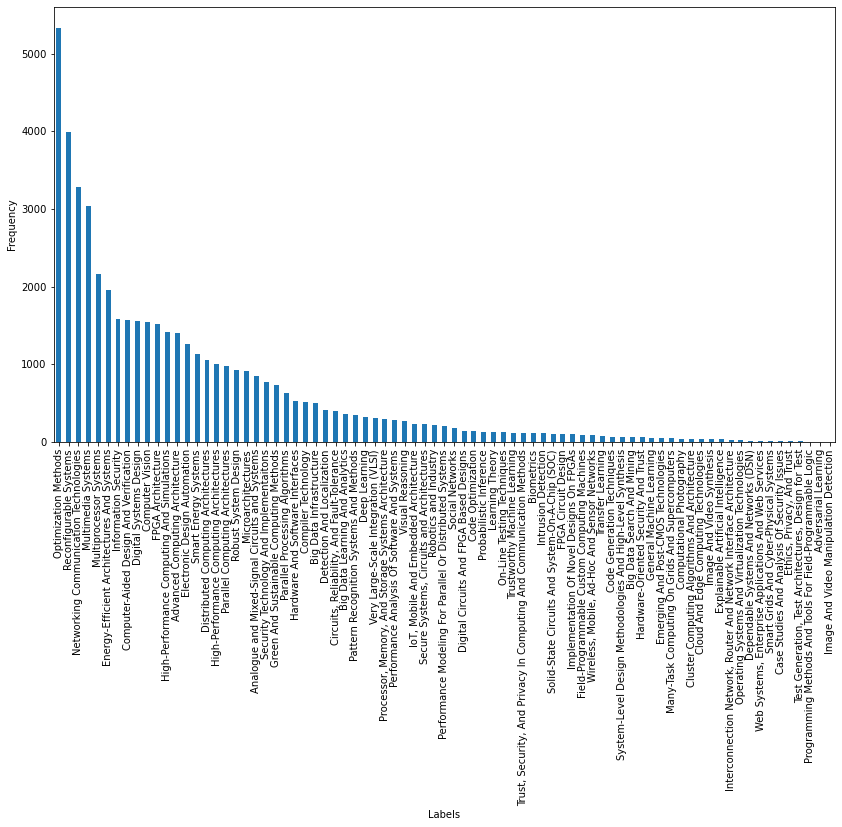

In [ ]:
barcount_plot(df_labeled["Label"], "Frequency of Labels with Title Only")

count    48611.000000
mean         0.731829
std          0.211105
min          0.003612
25%          0.607661
50%          0.785519
75%          0.903544
max          0.998633
Name: Confidence Score, dtype: float64


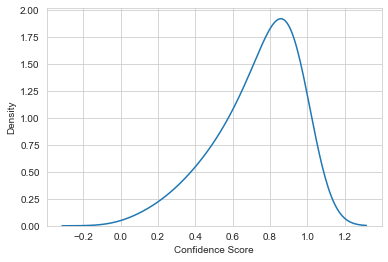

In [ ]:
sns.set_style('whitegrid')
sns.kdeplot(df_labeled['Confidence Score'], bw_method=0.5)

print(df_labeled['Confidence Score'].describe())